In [134]:
import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
from tqdm import tqdm

from modules import *
from networks import *
from training import *

COORDS = 'polar'  # cartesian, polar
ARCH = 'dual'  # dual, cascade
MODEL = 'ref'  # rau, ref, swin

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SIZE = 256 if MODEL != 'swin' else 224
transform = A.Compose([
    A.Resize(height=SIZE, width=SIZE, interpolation=cv.INTER_AREA),
    A.Lambda(image=sharpen, p=1.0),
    A.Lambda(image=polar_transform, mask=polar_transform),
    A.Normalize(),
    ToTensorV2(),
])

# Load dataset
all_images = load_files_from_dir(['../data/DRISHTI/ROI/TestImages'])
all_masks = load_files_from_dir(['../data/DRISHTI/ROI/TestMasks'])

# Shuffle
indices = np.random.permutation(len(all_images))
all_images = [all_images[i] for i in indices]
all_masks = [all_masks[i] for i in indices]

loader = load_dataset(
    all_images,
    all_masks,
    transform,
    batch_size=1,
    shuffle=False,
)

# Sample data
images, masks = next(iter(loader))
images = images.float().to(device)
masks = masks.long().to(device)

# Load models
path = rf"..\models\{COORDS}\{MODEL}\binary.pth"
checkpoint = load_checkpoint(path, map_location=device)
base_model = checkpoint['model']
base_model = base_model.eval()

path = rf"..\models\{COORDS}\{MODEL}\{ARCH}.pth"
checkpoint = load_checkpoint(path, map_location=device)
model = checkpoint['model']
model = model.eval()

Loaded dataset with 51 samples in 51 batches.
=> Loading checkpoint: ..\models\polar\ref\binary.pth
=> Loading checkpoint: ..\models\polar\ref\cascade.pth


In [135]:
from collections import defaultdict


def get_threshold_stats(mode, model, loader, base_model=None):
    data = []

    model.eval()
    with torch.no_grad():
        for images, masks in loader:
            preds, probs, loss = predict(
                mode, model, images, masks, base_model=base_model,
                post_process_fn=postprocess,
                inter_process_fn=interprocess if mode == 'cascade' else None,
            )

            od_probs = probs[:, 0, :, :]
            oc_probs = probs[:, 1, :, :]
            data.append((images, masks, od_probs, oc_probs))

    thresholds = np.linspace(0, 1, 101)

    tp_od = np.zeros_like(thresholds)
    tn_od = np.zeros_like(thresholds)
    fp_od = np.zeros_like(thresholds)
    fn_od = np.zeros_like(thresholds)

    tp_oc = np.zeros_like(thresholds)
    tn_oc = np.zeros_like(thresholds)
    fp_oc = np.zeros_like(thresholds)
    fn_oc = np.zeros_like(thresholds)

    for i, thresh in enumerate(thresholds):
        for images, masks, od_probs, oc_probs in data:
            od_preds = (od_probs > thresh).long()
            oc_preds = (oc_probs > thresh).long()

            preds = torch.zeros_like(oc_preds)
            preds[od_preds == 1] = 1
            preds[oc_preds == 1] = 2
            met = get_metrics(masks, preds, [[1, 2], [2]])

            tp_od[i] += met['tp_OD']
            tn_od[i] += met['tn_OD']
            fp_od[i] += met['fp_OD']
            fn_od[i] += met['fn_OD']

            tp_oc[i] += met['tp_OC']
            tn_oc[i] += met['tn_OC']
            fp_oc[i] += met['fp_OC']
            fn_oc[i] += met['fn_OC']

    metrics = defaultdict(lambda: np.zeros_like(thresholds))

    for i, (tp, tn, fp, fn) in enumerate(zip(tp_od, tn_od, fp_od, fn_od)):
        met = calculate_metrics(tp, tn, fp, fn)
        for k, v in met.items():
            metrics[f'{k}_OD'][i] = v

    for i, (tp, tn, fp, fn) in enumerate(zip(tp_oc, tn_oc, fp_oc, fn_oc)):
        met = calculate_metrics(tp, tn, fp, fn)
        for k, v in met.items():
            metrics[f'{k}_OC'][i] = v

    df = pd.DataFrame({'threshold': thresholds, **metrics})

    df['precision_OD'][100] = 1
    df['precision_OC'][100] = 1

    df['gmean_OD'] = np.sqrt(df['sensitivity_OD'] * df['specificity_OD'])
    df['gmean_OC'] = np.sqrt(df['sensitivity_OC'] * df['specificity_OC'])

    return df


def threshold_tuning_curve(df, tuning_metric: str = 'dice'):
    max_od_index = df[f'{tuning_metric}_OD'].idxmax()
    max_oc_index = df[f'{tuning_metric}_OC'].idxmax()

    best_threshold_od_tune = df['threshold'][max_od_index]
    best_threshold_oc_tune = df['threshold'][max_oc_index]

    plt.figure(figsize=(9, 6))
    plt.plot(df['threshold'], df[f'{tuning_metric}_OD'], label=f'OD {tuning_metric}')
    plt.plot(df['threshold'], df[f'{tuning_metric}_OC'], label=f'OC {tuning_metric}')
    plt.scatter(best_threshold_od_tune, df[f'{tuning_metric}_OD'][max_od_index], c='b',
                label=f'Best OD threshold: {best_threshold_od_tune:.2f}', zorder=3)
    plt.scatter(best_threshold_oc_tune, df[f'{tuning_metric}_OC'][max_oc_index], c='r',
                label=f'Best OC threshold: {best_threshold_oc_tune:.2f}', zorder=3)
    plt.xlabel('Threshold')
    plt.ylabel(tuning_metric.capitalize())
    plt.title(f'Threshold Tuning Curve for {tuning_metric.capitalize()}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_threshold_od_tune, best_threshold_oc_tune


def roc_curve(df):
    od_distances = np.sqrt(df['fpr_OD'] ** 2 + (1 - df['sensitivity_OD']) ** 2)
    oc_distances = np.sqrt(df['fpr_OC'] ** 2 + (1 - df['sensitivity_OC']) ** 2)

    min_index_od = od_distances.idxmin()
    min_index_oc = oc_distances.idxmin()

    best_threshold_od_roc = df['threshold'][min_index_od]
    best_threshold_oc_roc = df['threshold'][min_index_oc]

    plt.figure(figsize=(9, 6))
    plt.plot(df['fpr_OD'], df['sensitivity_OD'], label='OD curve')
    plt.plot(df['fpr_OC'], df['sensitivity_OC'], label='OC curve')
    plt.scatter(df['fpr_OD'][min_index_od], df['sensitivity_OD'][min_index_od], c='b',
                label=f'Best OD threshold: {best_threshold_od_roc:.2f}', zorder=3)
    plt.scatter(df['fpr_OC'][min_index_oc], df['sensitivity_OC'][min_index_oc], c='r',
                label=f'Best OC threshold: {best_threshold_oc_roc:.2f}', zorder=3)
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_threshold_od_roc, best_threshold_oc_roc


def precision_recall_curve(df):
    precision_od = df['precision_OD']
    recall_od = df['sensitivity_OD']

    precision_oc = df['precision_OC']
    recall_oc = df['sensitivity_OC']

    od_distances = np.sqrt((1 - precision_od) ** 2 + (1 - recall_od) ** 2)
    oc_distances = np.sqrt((1 - precision_oc) ** 2 + (1 - recall_oc) ** 2)

    min_index_od = od_distances.idxmin()
    min_index_oc = oc_distances.idxmin()

    best_threshold_od_pr = df['threshold'][min_index_od]
    best_threshold_oc_pr = df['threshold'][min_index_oc]

    plt.figure(figsize=(9, 6))
    plt.plot(recall_od, precision_od, label='OD curve', marker='.')
    plt.plot(recall_oc, precision_oc, label='OC curve', marker='.')
    plt.scatter(recall_od[min_index_od], precision_od[min_index_od], c='b',
                label=f'Best OD threshold: {best_threshold_od_pr:.2f}', zorder=3)
    plt.scatter(recall_oc[min_index_oc], precision_oc[min_index_oc], c='r',
                label=f'Best OC threshold: {best_threshold_oc_pr:.2f}', zorder=3)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_threshold_od_pr, best_threshold_oc_pr


def plot_curves(df, tuning_metric: str = 'dice'):
    # Threshold Tuning
    max_od_index = df[f'{tuning_metric}_OD'].idxmax()
    max_oc_index = df[f'{tuning_metric}_OC'].idxmax()
    best_threshold_od_tune_dice = df['threshold'][max_od_index]
    best_threshold_oc_tune_dice = df['threshold'][max_oc_index]

    # Threshold Tuning G-Mean
    max_od_index = df['gmean_OD'].idxmax()
    max_oc_index = df['gmean_OC'].idxmax()
    best_threshold_od_tune_gmean = df['threshold'][max_od_index]
    best_threshold_oc_tune_gmean = df['threshold'][max_oc_index]

    # ROC Curve
    od_distances = np.sqrt(df['fpr_OD'] ** 2 + (1 - df['sensitivity_OD']) ** 2)
    oc_distances = np.sqrt(df['fpr_OC'] ** 2 + (1 - df['sensitivity_OC']) ** 2)
    min_index_od = od_distances.idxmin()
    min_index_oc = oc_distances.idxmin()
    best_threshold_od_roc = df['threshold'][min_index_od]
    best_threshold_oc_roc = df['threshold'][min_index_oc]

    # Precision-Recall Curve
    precision_od = df['precision_OD']
    recall_od = df['sensitivity_OD']
    precision_oc = df['precision_OC']
    recall_oc = df['sensitivity_OC']
    od_distances = np.sqrt((1 - precision_od) ** 2 + (1 - recall_od) ** 2)
    oc_distances = np.sqrt((1 - precision_oc) ** 2 + (1 - recall_oc) ** 2)
    min_index_od = od_distances.idxmin()
    min_index_oc = oc_distances.idxmin()
    best_threshold_od_pr = df['threshold'][min_index_od]
    best_threshold_oc_pr = df['threshold'][min_index_oc]

    # Setup subplot layout
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
    axes = axes.ravel()

    # Threshold Tuning Curve
    axes[0].plot(df['threshold'], df[f'{tuning_metric}_OD'], label=f'OD curve')
    axes[0].plot(df['threshold'], df[f'{tuning_metric}_OC'], label=f'OC curve')
    axes[0].scatter(best_threshold_od_tune_dice, df[f'{tuning_metric}_OD'][max_od_index], c='b',
                    label=f'Best OD threshold: {best_threshold_od_tune_dice:.2f}', zorder=3)
    axes[0].scatter(best_threshold_oc_tune_dice, df[f'{tuning_metric}_OC'][max_oc_index], c='r',
                    label=f'Best OC threshold: {best_threshold_oc_tune_dice:.2f}', zorder=3)
    axes[0].set_xlabel('Threshold')
    axes[0].set_ylabel(tuning_metric.capitalize())
    axes[0].set_title(f'Threshold Tuning Curve for {tuning_metric.capitalize()}')
    axes[0].legend()
    axes[0].grid(True)

    # Threshold Tuning Curve G-Mean
    axes[1].plot(df['threshold'], df['gmean_OD'], label=f'OD curve')
    axes[1].plot(df['threshold'], df['gmean_OC'], label=f'OC curve')
    axes[1].scatter(best_threshold_od_tune_gmean, df['gmean_OD'][max_od_index], c='b',
                    label=f'Best OD threshold: {best_threshold_od_tune_gmean:.2f}', zorder=3)
    axes[1].scatter(best_threshold_oc_tune_gmean, df['gmean_OC'][max_oc_index], c='r',
                    label=f'Best OC threshold: {best_threshold_oc_tune_gmean:.2f}', zorder=3)
    axes[1].set_xlabel('Threshold')
    axes[1].set_ylabel('G-Mean')
    axes[1].set_title('Threshold Tuning Curve for G-Mean')
    axes[1].legend()
    axes[1].grid(True)

    # ROC Curve
    axes[2].plot(df['fpr_OD'], df['sensitivity_OD'], label='OD curve')
    axes[2].plot(df['fpr_OC'], df['sensitivity_OC'], label='OC curve')
    axes[2].scatter(df['fpr_OD'][min_index_od], df['sensitivity_OD'][min_index_od], c='b',
                    label=f'Best OD threshold: {best_threshold_od_roc:.2f}', zorder=3)
    axes[2].scatter(df['fpr_OC'][min_index_oc], df['sensitivity_OC'][min_index_oc], c='r',
                    label=f'Best OC threshold: {best_threshold_oc_roc:.2f}', zorder=3)
    axes[2].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate')
    axes[2].set_title('ROC Curve')
    axes[2].legend()
    axes[2].grid(True)

    # Precision-Recall Curve
    axes[3].plot(recall_od, precision_od, label='OD curve', marker='.')
    axes[3].plot(recall_oc, precision_oc, label='OC curve', marker='.')
    axes[3].scatter(recall_od[min_index_od], precision_od[min_index_od], c='b',
                    label=f'Best OD threshold: {best_threshold_od_pr:.2f}', zorder=3)
    axes[3].scatter(recall_oc[min_index_oc], precision_oc[min_index_oc], c='r',
                    label=f'Best OC threshold: {best_threshold_oc_pr:.2f}', zorder=3)
    axes[3].set_xlabel('Recall')
    axes[3].set_ylabel('Precision')
    axes[3].set_title('Precision-Recall Curve')
    axes[3].legend()
    axes[3].grid(True)

    plt.tight_layout()
    plt.show()

    return {
        f'tuning {tuning_metric}': {
            'OD': best_threshold_od_tune_dice,
            'OC': best_threshold_oc_tune_dice,
        },
        'tuning gmean': {
            'OD': best_threshold_od_tune_gmean,
            'OC': best_threshold_oc_tune_gmean,
        },
        'roc': {
            'OD': best_threshold_od_roc,
            'OC': best_threshold_oc_roc,
        },
        'pr': {
            'OD': best_threshold_od_pr,
            'OC': best_threshold_oc_pr,
        },
    }

In [136]:
df = get_threshold_stats(ARCH, model, loader, base_model=base_model if ARCH == 'cascade' else None)
df

,threshold,accuracy_OD,precision_OD,npv_OD,sensitivity_OD,specificity_OD,fpr_OD,fnr_OD,dice_OD,iou_OD,...,fnr_OC,dice_OC,iou_OC,balance_accuracy_OC,tp_OC,tn_OC,fp_OC,fn_OC,gmean_OD,gmean_OC
0,0.00,0.401042,0.401042,0.000000,1.000000,0.000000,1.000000,0.000000,0.572491,0.401042,...,0.000000,0.450985,0.291143,0.500000,973097.0,0.0,2369239.0,0.0,0.000000,0.000000
1,0.01,0.974662,0.942484,0.998402,0.997707,0.959233,0.040767,0.002293,0.969309,0.940446,...,0.001010,0.854943,0.746638,0.930086,972114.0,2040348.0,328891.0,983.0,0.978281,0.927531
2,0.02,0.980790,0.958345,0.996814,0.995365,0.971032,0.028968,0.004635,0.976504,0.954087,...,0.004955,0.901468,0.820612,0.953870,968275.0,2162393.0,206846.0,4822.0,0.983123,0.952981
3,0.03,0.982996,0.964703,0.995877,0.993968,0.975649,0.024351,0.006032,0.979117,0.959088,...,0.009516,0.914815,0.843003,0.959315,963837.0,2198999.0,170240.0,9260.0,0.984766,0.958808
4,0.04,0.984076,0.968162,0.995195,0.992947,0.978136,0.021864,0.007053,0.980398,0.961549,...,0.013756,0.921288,0.854063,0.961339,959711.0,2218636.0,150603.0,13386.0,0.985514,0.961016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0.967373,0.999473,0.948617,0.919128,0.999675,0.000325,0.080872,0.957618,0.918683,...,0.250966,0.851356,0.741184,0.872342,728883.0,2358932.0,10307.0,244214.0,0.958556,0.863583
97,0.97,0.964819,0.999625,0.944714,0.912617,0.999771,0.000229,0.087383,0.954142,0.912305,...,0.278224,0.834300,0.715707,0.859147,702358.0,2360988.0,8251.0,270739.0,0.955201,0.848093
98,0.98,0.960821,0.999799,0.938705,0.902489,0.999879,0.000121,0.097511,0.948655,0.902326,...,0.323230,0.804167,0.672474,0.837073,658563.0,2363023.0,6216.0,314534.0,0.949937,0.821581
99,0.99,0.952623,0.999968,0.926714,0.881893,0.999981,0.000019,0.118107,0.937226,0.881868,...,0.430723,0.723412,0.566677,0.783696,553962.0,2364773.0,4466.0,419135.0,0.939083,0.753793


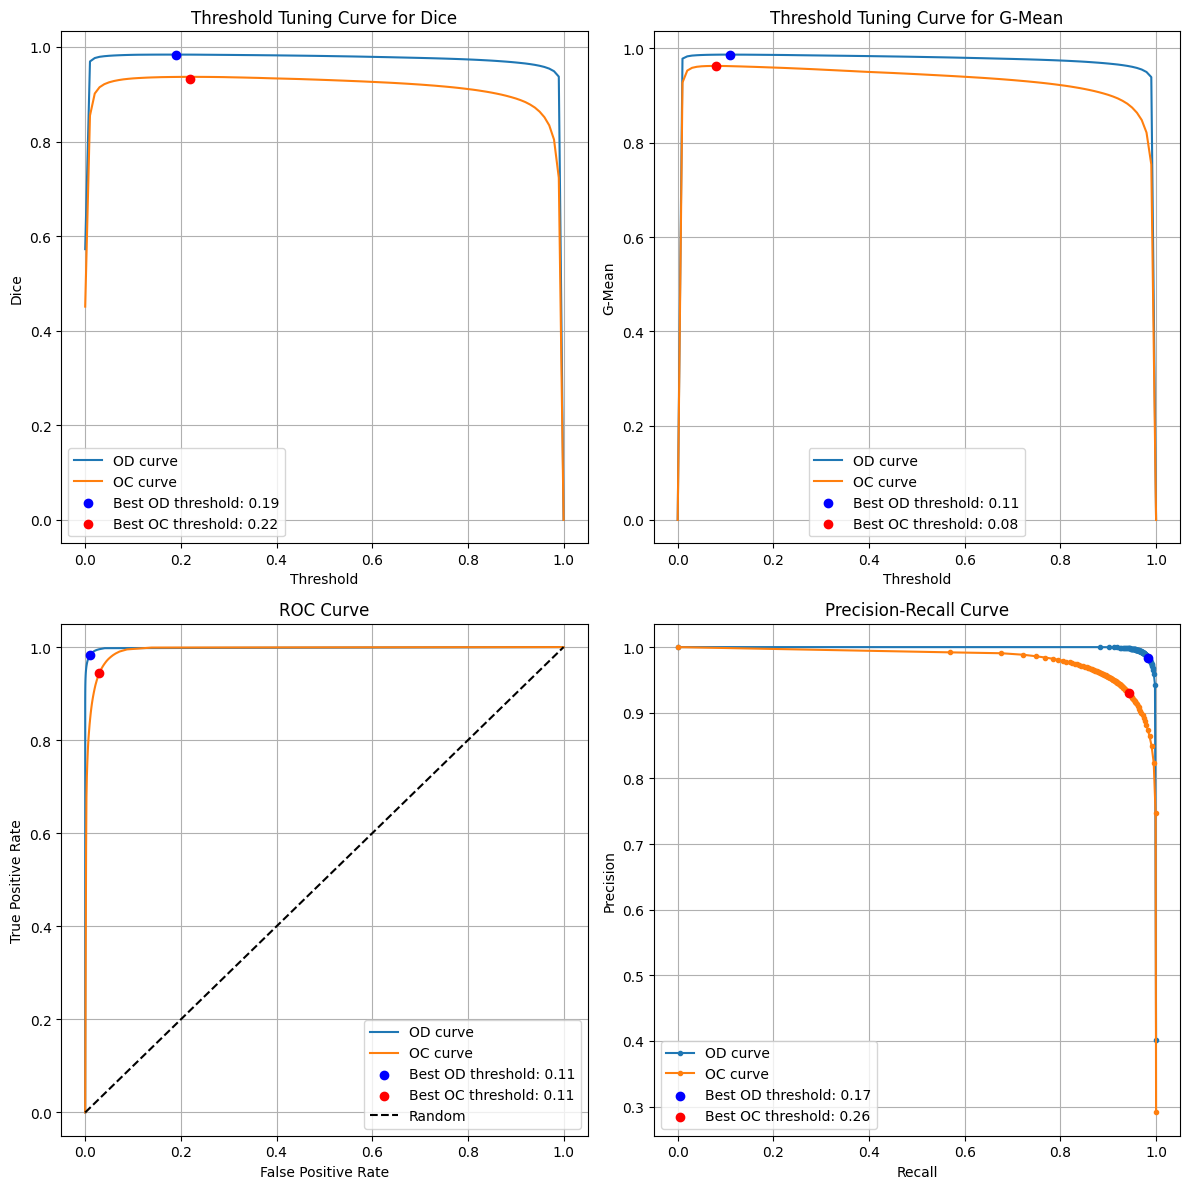

In [137]:
optimal_values = plot_curves(df, tuning_metric='dice')

In [138]:
od_thresh = optimal_values['pr']['OD']
oc_thresh = optimal_values['pr']['OC']

res = evaluate(
    ARCH, model, loader,
    od_thresh=od_thresh,
    oc_thresh=oc_thresh,
    base_model=base_model if ARCH == 'cascade' else None,
    inter_process_fn=interprocess if ARCH == 'cascade' else None,
    inverse_transform=undo_polar_transform,
    post_process_fn=postprocess,
    tta=False,
)
print(COORDS, ARCH, MODEL, od_thresh, oc_thresh, optimal_values)
print(
    f'OD - Acc: {res["accuracy_OD"]:.4f}  Sen: {res["sensitivity_OD"]:.4f}  Spe: {res["specificity_OD"]:.4f}  Dice: {res["dice_OD"]:.4f}  IOU: {res["iou_OD"]:.4f}')
print(
    f'OC - Acc: {res["accuracy_OC"]:.4f}  Sen: {res["sensitivity_OC"]:.4f}  Spe: {res["specificity_OC"]:.4f}  Dice: {res["dice_OC"]:.4f}  IOU: {res["iou_OC"]:.4f}')

Evaluating cascade segmentation: 100%|██████████| 51/51 [00:08<00:00,  5.76it/s, accuracy_OC=0.967, accuracy_OD=0.984, balance_accuracy_OC=0.95, balance_accuracy_OD=0.98, dice_OC=0.872, dice_OD=0.969, fn_OC=846, fn_OD=519, fnr_OC=0.0783, fnr_OD=0.0283, fp_OC=1.31e+3, fp_OD=533, fpr_OC=0.0224, fpr_OD=0.0111, iou_OC=0.786, iou_OD=0.941, npv_OC=0.985, npv_OD=0.989, precision_OC=0.862, precision_OD=0.968, sensitivity_OC=0.922, sensitivity_OD=0.972, specificity_OC=0.978, specificity_OD=0.989, tn_OC=5.5e+4, tn_OD=4.82e+4, tp_OC=8.42e+3, tp_OD=1.63e+4]   

polar cascade ref 0.17 0.26 {'tuning dice': {'OD': 0.19, 'OC': 0.22}, 'tuning gmean': {'OD': 0.11, 'OC': 0.08}, 'roc': {'OD': 0.11, 'OC': 0.11}, 'pr': {'OD': 0.17, 'OC': 0.26}}
OD - Acc: 0.9839  Sen: 0.9717  Spe: 0.9889  Dice: 0.9693  IOU: 0.9409
OC - Acc: 0.9672  Sen: 0.9217  Spe: 0.9776  Dice: 0.8719  IOU: 0.7864


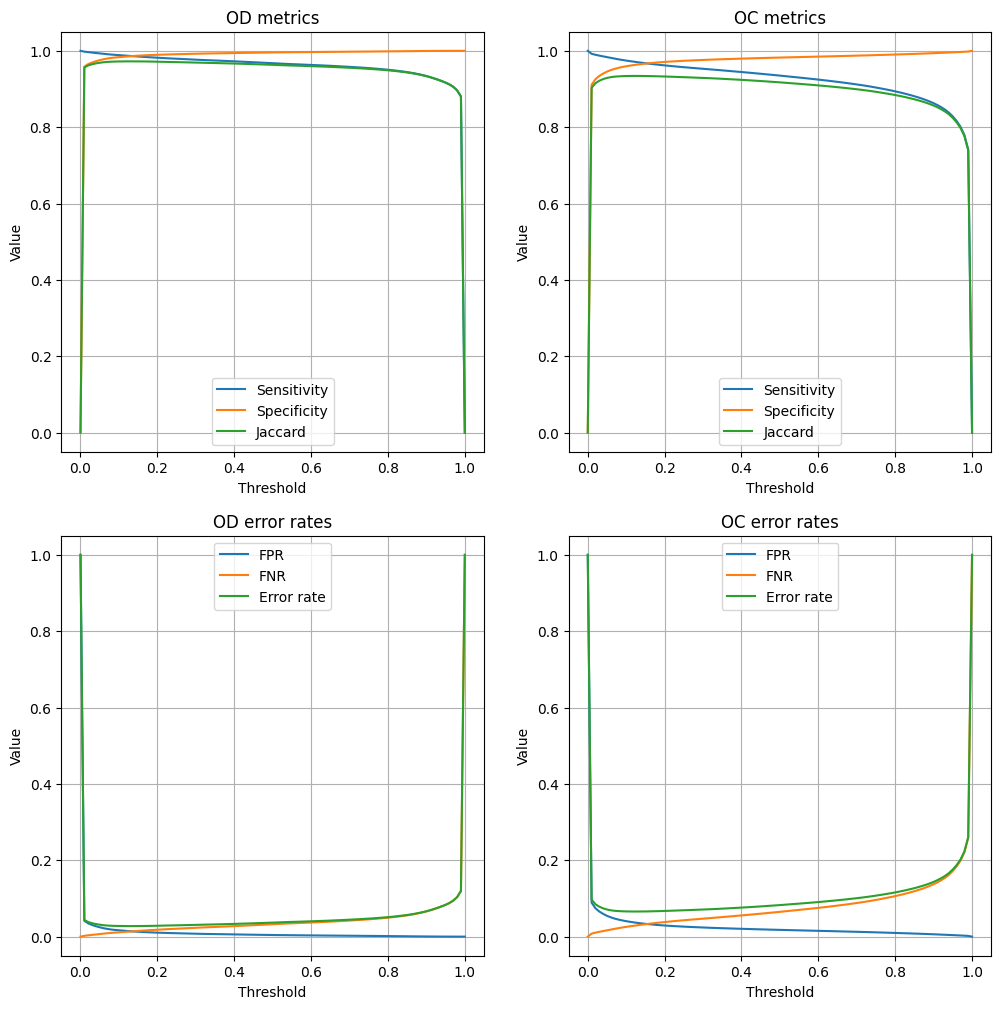

In [6]:
# Plot metrics
_, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].plot(df['threshold'], df['sensitivity_OD'], label='Sensitivity')
ax[0, 0].plot(df['threshold'], df['specificity_OD'], label='Specificity')
ax[0, 0].plot(df['threshold'], df['specificity_OD'] + df['sensitivity_OD'] - 1, label='Jaccard')
ax[0, 0].set_xlabel('Threshold')
ax[0, 0].set_ylabel('Value')
ax[0, 0].set_title('OD metrics')
ax[0, 0].legend()
ax[0, 0].grid(True)

ax[0, 1].plot(df['threshold'], df['sensitivity_OC'], label='Sensitivity')
ax[0, 1].plot(df['threshold'], df['specificity_OC'], label='Specificity')
ax[0, 1].plot(df['threshold'], df['specificity_OC'] + df['sensitivity_OC'] - 1, label='Jaccard')
ax[0, 1].set_xlabel('Threshold')
ax[0, 1].set_ylabel('Value')
ax[0, 1].set_title('OC metrics')
ax[0, 1].legend()
ax[0, 1].grid(True)

ax[1, 0].plot(df['threshold'], df['fpr_OD'], label='FPR')
ax[1, 0].plot(df['threshold'], df['fnr_OD'], label='FNR')
ax[1, 0].plot(df['threshold'], df['fpr_OD'] + df['fnr_OD'], label='Error rate')
ax[1, 0].set_xlabel('Threshold')
ax[1, 0].set_ylabel('Value')
ax[1, 0].set_title('OD error rates')
ax[1, 0].legend()
ax[1, 0].grid(True)

ax[1, 1].plot(df['threshold'], df['fpr_OC'], label='FPR')
ax[1, 1].plot(df['threshold'], df['fnr_OC'], label='FNR')
ax[1, 1].plot(df['threshold'], df['fpr_OC'] + df['fnr_OC'], label='Error rate')
ax[1, 1].set_xlabel('Threshold')
ax[1, 1].set_ylabel('Value')
ax[1, 1].set_title('OC error rates')
ax[1, 1].legend()
ax[1, 1].grid(True)

plt.show()

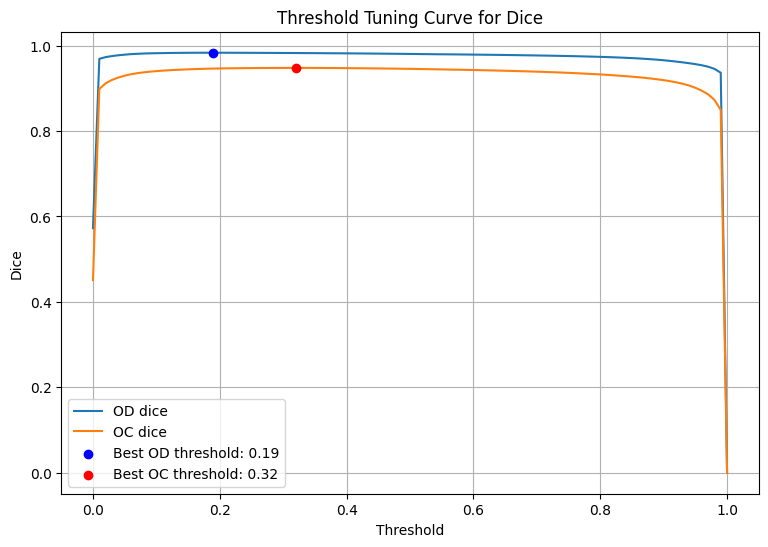

(0.19, 0.32)

In [7]:
threshold_tuning_curve(df, tuning_metric='dice')

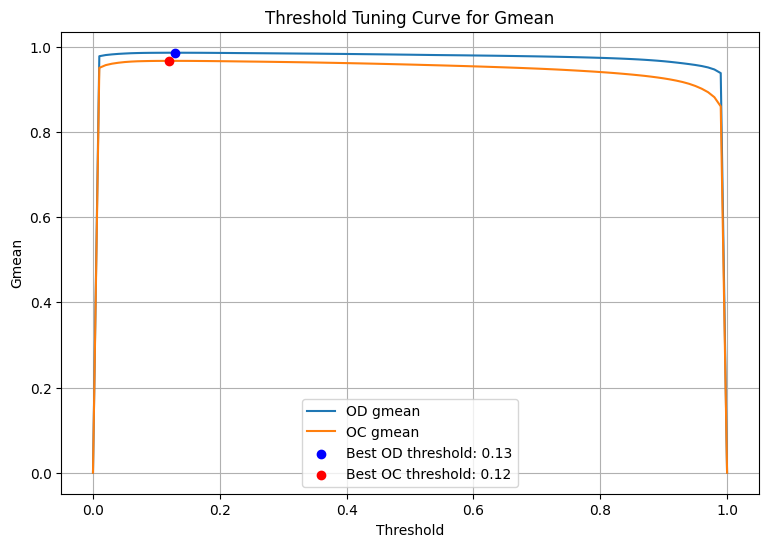

(0.13, 0.12)

In [8]:
threshold_tuning_curve(df, tuning_metric='gmean')

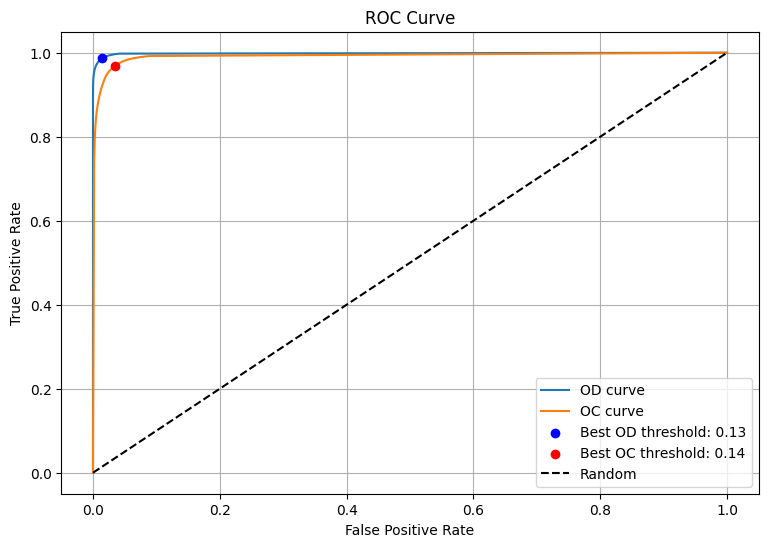

(0.13, 0.14)

In [9]:
roc_curve(df)

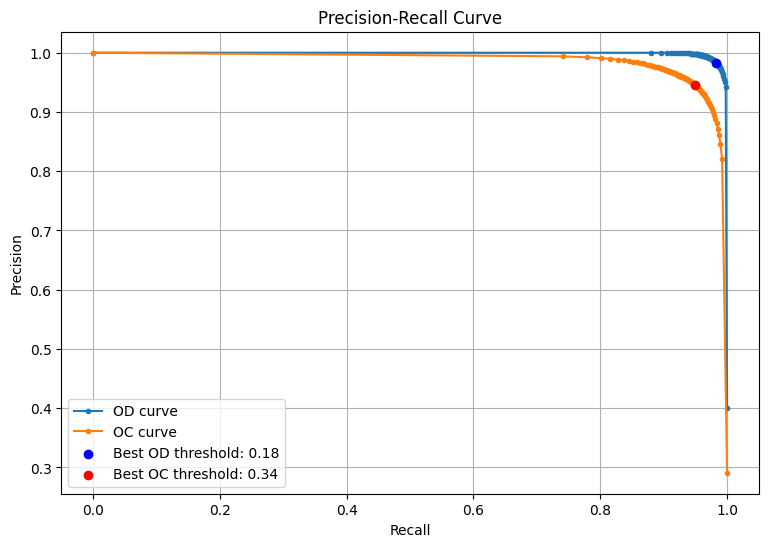

(0.18, 0.34)

In [10]:
precision_recall_curve(df)

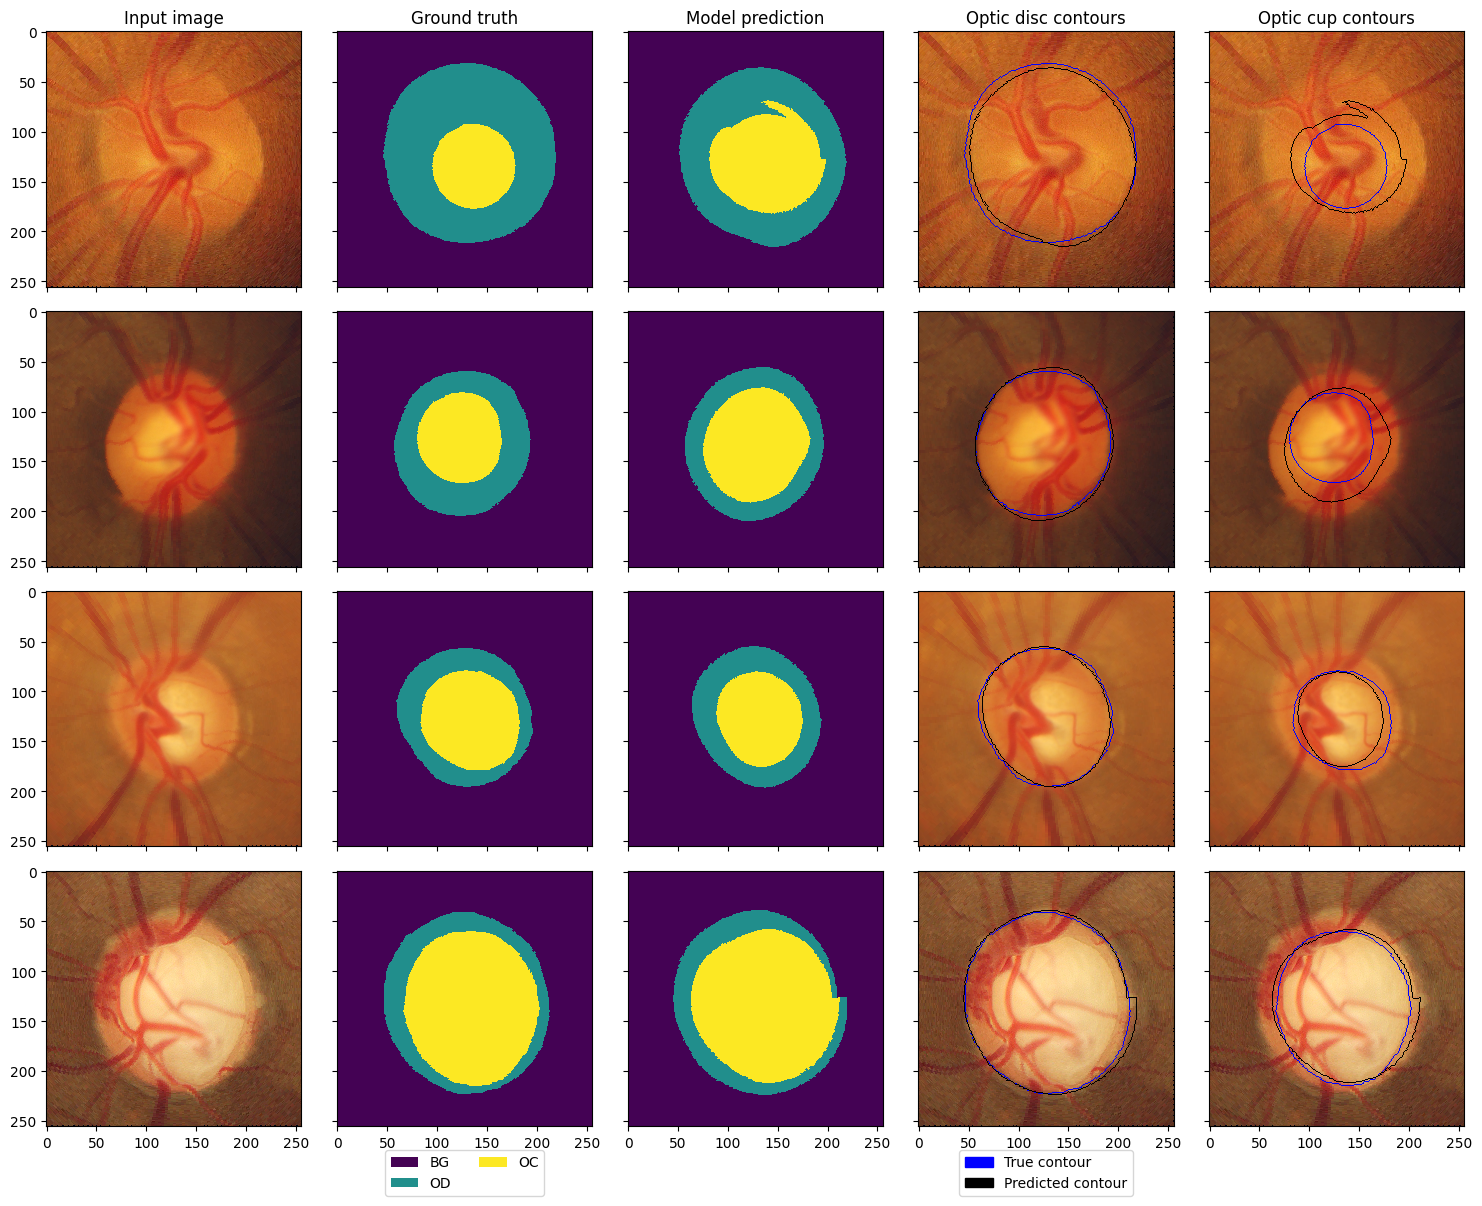

In [141]:
plot_results_from_loader(
    ARCH, loader, model, device, base_model=base_model,
    n_samples=4, od_thresh=od_thresh, oc_thresh=oc_thresh,
    post_process_fn=postprocess,
    inter_process_fn=interprocess if ARCH == 'cascade' else None,
    inverse_transform=undo_polar_transform,
    types=['image', 'mask', 'prediction', 'OD contour', 'OC contour'],
)

torch.Size([1, 3, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 256, 256]) torch.Size([1, 2, 256, 256]) tensor(0.0962, device='cuda:0')


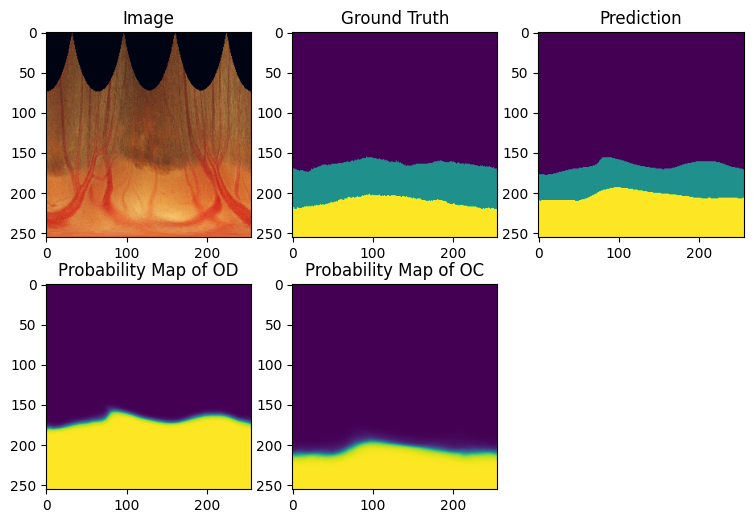

In [192]:
criterion = ComboLoss(1)

for images, masks in loader:
    images, masks = images.float(), masks.long()
    print(images.shape, masks.shape)
    preds, probs, loss = predict_dual(model, images, masks, device, criterion, od_threshold=0.2, oc_threshold=0.25)
    print(preds.shape, probs.shape, loss)

    for i in range(images.shape[0]):
        img = images[i].detach().cpu().numpy().transpose(1, 2, 0)
        img -= img.min()
        img /= img.max()
        mask = masks[i].detach().cpu().numpy()
        pred = preds[i].detach().cpu().numpy()
        prob = probs[i].detach().cpu().numpy()

        plt.figure(figsize=(9, 6))
        plt.subplot(2, 3, 1)
        plt.imshow(img)
        plt.title('Image')

        plt.subplot(2, 3, 2)
        plt.imshow(mask)
        plt.title('Ground Truth')

        plt.subplot(2, 3, 3)
        plt.imshow(pred)
        plt.title('Prediction')

        prob_od = inverse_polar_transform(prob[0])
        prob_oc = inverse_polar_transform(prob[1])

        plt.subplot(2, 3, 4)
        plt.imshow(prob[0])
        plt.title('Probability Map of OD')

        plt.subplot(2, 3, 5)
        plt.imshow(prob[1])
        plt.title('Probability Map of OC')

        plt.subplot(2, 3, 6)
        plt.axis('off')
        plt.show()
    break